![dvd_image]()

.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. 

In [140]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


# Import any additional modules and start coding below

In [141]:
df=pd.read_csv('rental_info.csv')
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


# Model EDA

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [143]:
df.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [144]:
df.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


# Data Cleaning

To create target variable we need to convert dates to datetime object and then calculate difference 

In [145]:
print(type(df.rental_date[0]))

#Change to datetime
df['rental_date']=pd.to_datetime(df['rental_date'])
df['return_date']=pd.to_datetime(df['return_date'])

print(type(df.rental_date[0]))

#Generate target variable 
df['rental_length_days']=(df['return_date']-df['rental_date']).dt.days
df['rental_length_days']

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: rental_length_days, Length: 15861, dtype: int64

In [146]:
#Generate new columns to represent special fetures and convert categorical to numerical 
df['deleted_scenes']=np.where(df['special_features'].str.contains('Deleted Scenes'),1,0)

df['behind_the_scenes']=np.where(df['special_features'].str.contains('Behind the Scenes'),1,0)

In [147]:
#Defining X,y and dropping redundant columns and target variable 
X=df.drop(['rental_date','return_date','rental_length_days','special_features'], axis=1)
y=df['rental_length_days']

#Train test split
X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=.2, random_state=9)

# Feature Engineering

We will use Lasso regression to identify the most important features by subsetting those with coefficients > 0

In [148]:
#Testing Features 
scaler=StandardScaler()
model=Lasso(alpha=.1, random_state=9)

steps=[("scale", scaler),("model",model)]

pipeline=Pipeline(steps)
pipeline.fit(X_train,y_train)


Pipeline(steps=[('scale', StandardScaler()),
                ('model', Lasso(alpha=0.1, random_state=9))])

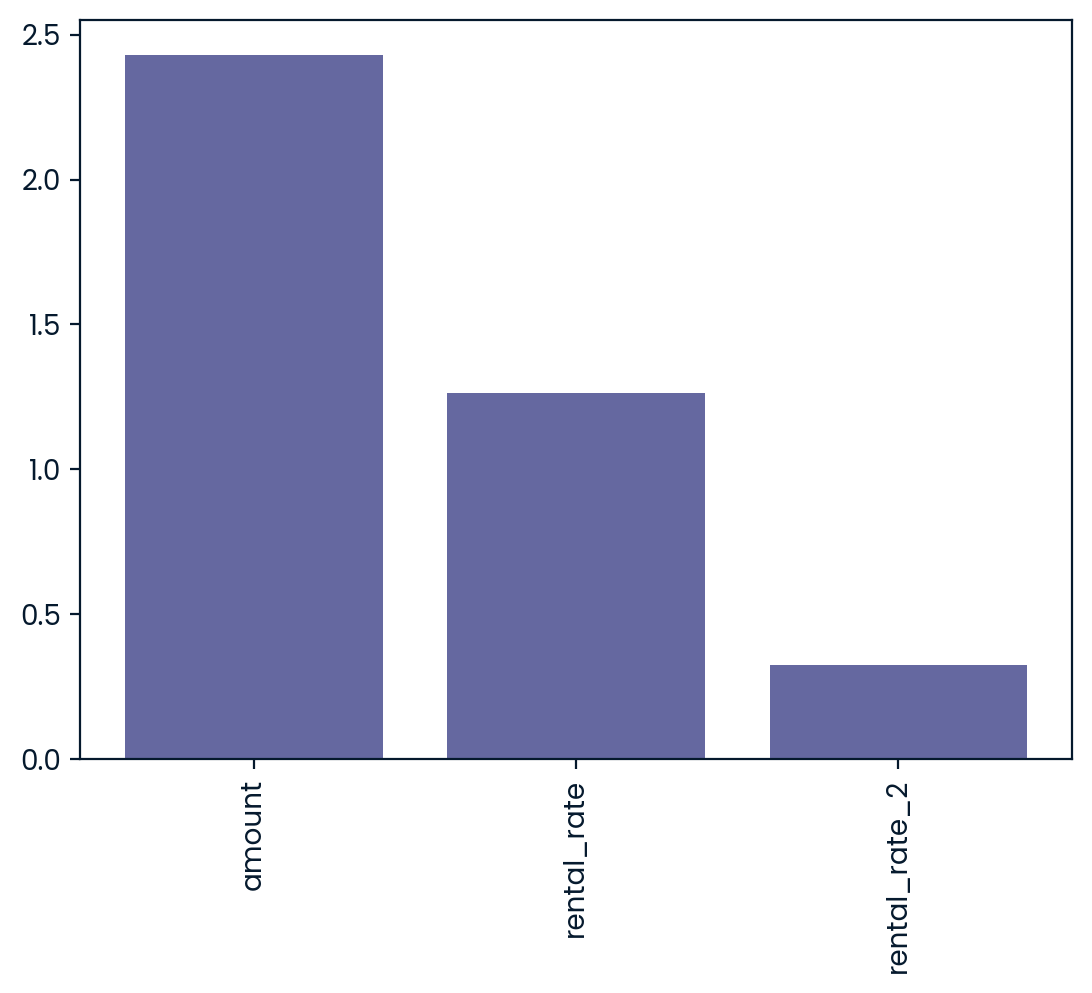

In [149]:
import matplotlib.pyplot as plt
feature_importance = list(zip(X.columns, np.abs(model.coef_)))

#Subset features that are above 0 
important_features=[ pair for pair in feature_importance if pair[1]>0]

plt.bar([pair[0] for pair in important_features], [pair[1] for pair in important_features])
plt.xticks(rotation=90) 
plt.show()


Only two three features were above 0 so we will keep training the model and evaluate performance 

# Evaluating Various Regression Models

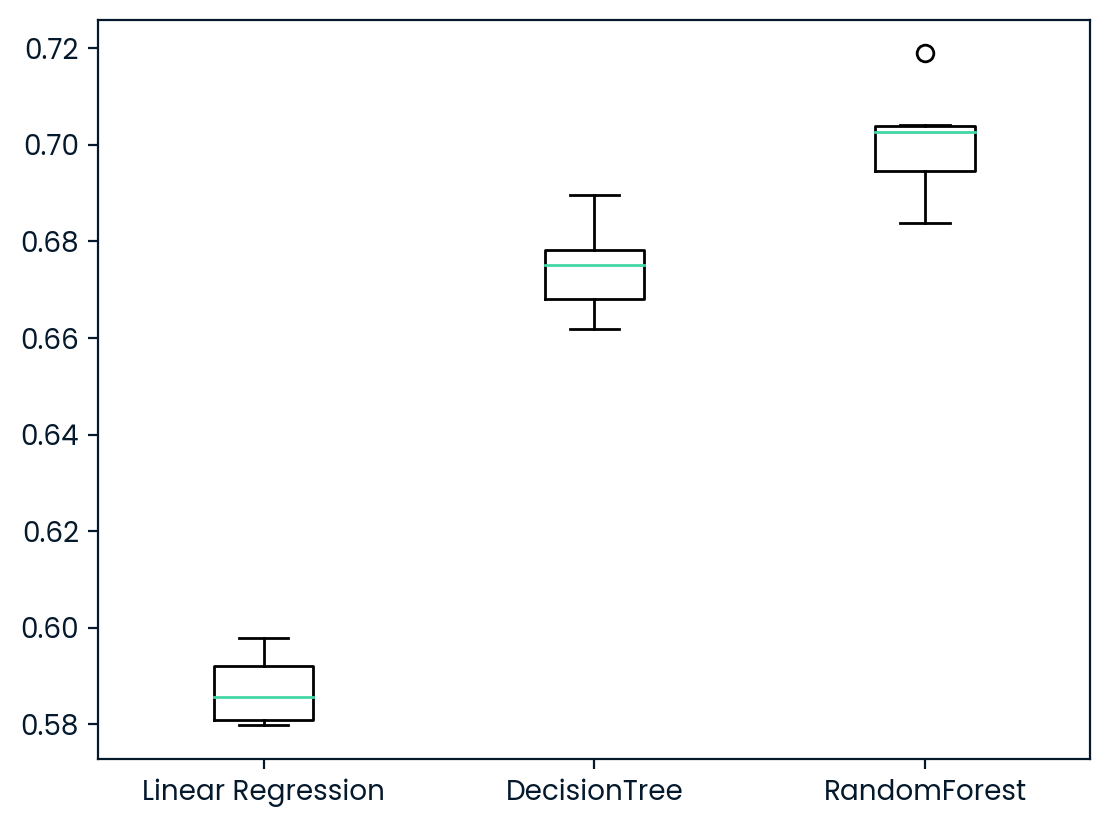

Linear Regression Test Set MSE: 2.9417238646975976
DecisionTree Test Set MSE: 2.1632301661728883
RandomForest Test Set MSE: 2.0315228605349076


In [150]:
models = {"Linear Regression": LinearRegression(), "DecisionTree": DecisionTreeRegressor(), "RandomForest": RandomForestRegressor()}
results = []

for model in models.values():
  kf = KFold(n_splits=6, random_state=9, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()


for name,model in models.items():
    steps=[("scale", scaler),(name,model)]
    pipeline=Pipeline(steps)
    pipeline.fit(X_train,y_train)
    y_pred=pipeline.predict(X_test)
    test_mse= mean_squared_error(y_test,y_pred)
    print("{} Test Set MSE: {}".format(name, test_mse))
    

# Hypertuning

In [151]:
#Hypertuning 

# Define the parameter space 
param_test=  {'n_estimators': np.arange(1,101,1),'max_depth':np.arange(3,11,1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],}


#Define model and pipeline 
regressor_model=RandomForestRegressor()

# Set up the grid search with cross-validation
regressor_cv = RandomizedSearchCV(regressor_model, param_distributions=param_test, cv=5,random_state=9)


#Train the model 
regressor_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=9)

In [152]:
#Display best parameters 
params=regressor_cv.best_params_
params

{'n_estimators': 83,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 10}

In [153]:
#Run the model with hypertuned parameters to obtain maximum performance 

#Define model and pipeline
rf_model=RandomForestRegressor(n_estimators=83, max_depth=10,min_samples_split=5,min_samples_leaf=2, random_state=9)
steps=[("scale", scaler),("RandomForest",rf_model)]
tuned_model=Pipeline(steps)
tuned_model.fit(X_train, y_train)

#Make predictions using best model
y_pred=tuned_model.predict(X_test)

#Calculate mean squared error and R squared
best_mse=mean_squared_error(y_test,y_pred)
r=r2_score(y_test,y_pred)

print("MSE:",best_mse)
print("R-Squared:",r)


MSE: 2.226297793760813
R-Squared: 0.6864179621598594
